## Bike Rental DataSet from UCI Machine Learning Repository

### Model improovement

#### By Matthieu Hanania & Karis Gwet

## Model done in class

In [0]:
spark.read.csv("/FileStore/tables/Bike_Rental_UCI_dataset.csv", inferSchema=True, header = True).show(10)

+------+---+----+---+-------+----------+----------+----+----+---------+---------+----+------+
|season| yr|mnth| hr|holiday|workingday|weathersit|temp| hum|windspeed|dayOfWeek|days|demand|
+------+---+----+---+-------+----------+----------+----+----+---------+---------+----+------+
|     1|  0|   1|  0|      0|         0|         1|0.24|0.81|      0.0|      Sat|   0|    16|
|     1|  0|   1|  1|      0|         0|         1|0.22| 0.8|      0.0|      Sat|   0|    40|
|     1|  0|   1|  2|      0|         0|         1|0.22| 0.8|      0.0|      Sat|   0|    32|
|     1|  0|   1|  3|      0|         0|         1|0.24|0.75|      0.0|      Sat|   0|    13|
|     1|  0|   1|  4|      0|         0|         1|0.24|0.75|      0.0|      Sat|   0|     1|
|     1|  0|   1|  5|      0|         0|         2|0.24|0.75|   0.0896|      Sat|   0|     1|
|     1|  0|   1|  6|      0|         0|         1|0.22| 0.8|      0.0|      Sat|   0|     2|
|     1|  0|   1|  7|      0|         0|         1| 0.2|0.86

In [0]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import avg, stddev, format_number

#read csv
rowData = spark.read.csv("/FileStore/tables/Bike_Rental_UCI_dataset.csv", inferSchema=True, header = True)

#transform string values into categories
indexer = StringIndexer(inputCol='dayOfWeek', outputCol='day_cat')
indexed_data =indexer.fit(rowData).transform(rowData)

#One vectors that contains all the information
vec = VectorAssembler(inputCols= ['season','yr','mnth','hr','holiday','workingday','weathersit','temp','hum','windspeed','day_cat'],outputCol = 'features')
data = vec.transform(indexed_data)

#setup the model on the features column
modelData = data.select('features', 'demand') 
trainData, testData = modelData.randomSplit([0.7, 0.3])

#create the linearRegression model
lr = LinearRegression(labelCol='demand')
lrModel = lr.fit(trainData)

#vizualise the model's performance
summary = lrModel.summary
summary.r2
summary.predictions.show(n=20, truncate = False)

print ("explainedVariance={}".format(summary.explainedVariance))
print ("meanAbsoluteError=%g" %summary.meanAbsoluteError)

#test the model on the test Data
testResults = lrModel.evaluate(testData)
testResults.residuals.show(n=10)

print ("r2=%g"%testResults.r2)   # my model explains x % of the variance of the data
print ("rootMeanSquaredError=%g"%testResults.rootMeanSquaredError)

#calculate prediction
pred = lrModel.evaluate(data).predictions

+-----------------------------------------------+------+-------------------+
|features                                       |demand|prediction         |
+-----------------------------------------------+------+-------------------+
|(11,[0,1,2,6,7,8],[1.0,1.0,12.0,2.0,0.24,0.7]) |26.0  |14.064154410890401 |
|(11,[0,1,2,6,7,8],[2.0,1.0,3.0,1.0,0.58,0.68]) |156.0 |140.22157579429336 |
|(11,[0,1,2,6,7,8],[3.0,1.0,8.0,2.0,0.7,0.61])  |135.0 |203.49612919377998 |
|(11,[0,1,2,6,7,8],[4.0,1.0,12.0,1.0,0.26,0.81])|108.0 |63.79250473763144  |
|(11,[0,1,2,6,7,8],[4.0,1.0,12.0,1.0,0.3,0.7])  |94.0  |96.73737840019764  |
|(11,[0,2,3,6,7,8],[1.0,1.0,1.0,1.0,0.22,0.8])  |40.0  |-82.28722612784948 |
|(11,[0,2,3,6,7,8],[1.0,1.0,2.0,1.0,0.22,0.8])  |32.0  |-74.65389674435019 |
|(11,[0,2,3,6,7,8],[1.0,1.0,2.0,2.0,0.18,0.55]) |16.0  |-40.816942647088375|
|(11,[0,2,3,6,7,8],[1.0,1.0,3.0,1.0,0.24,0.75]) |13.0  |-51.532146037177036|
|(11,[0,2,3,6,7,8],[1.0,1.0,4.0,1.0,0.24,0.75]) |1.0   |-43.89881665367775 |

### average demande vs prediction by hour, season, and plot by temp and weather

In [0]:
#Hour and demand. We can see that dempending of the hour, it is not always the same season that gets the highest demand
import pyspark.sql.functions as F
pred.groupBy("hr", "season").agg(
    F.avg("demand").alias("avg_real_demand"), F.avg("prediction").alias("avg_predicted_demand"),
    F.stddev("demand").alias("std_real_demand"), F.stddev("prediction").alias("std_predicted_demand")
).sort('avg_real_demand').sort('hr').show()

+---+------+------------------+--------------------+------------------+--------------------+
| hr|season|   avg_real_demand|avg_predicted_demand|   std_real_demand|std_predicted_demand|
+---+------+------------------+--------------------+------------------+--------------------+
|  0|     4|56.333333333333336|   81.16707266490376| 43.73352503653475|   60.66634111286649|
|  0|     1| 27.40449438202247|  11.519972052120973|21.243393975445947|    69.0289752062213|
|  0|     2| 56.84239130434783|     83.713419550078| 40.34688586027427|   69.95207127082286|
|  0|     3|  73.9144385026738|   140.0087962573875| 45.24809928973331|  57.760906783411905|
|  1|     2| 35.22282608695652|   84.75939402648382|  31.9912781941294|    68.6600587431631|
|  1|     1|18.140449438202246|  14.677668255409694|19.078708333146423|   67.72999440019939|
|  1|     3| 43.72043010752688|  143.23298120740958| 37.77726059671858|  56.070670818199055|
|  1|     4| 35.92045454545455|   84.48118184147617|  36.6092015258956

In [0]:
#working day has no a important impat on the demand
import pyspark.sql.functions as F
pred.groupBy("workingday").agg(
    F.avg("demand").alias("avg_real_demand"), F.avg("prediction").alias("avg_predicted_demand"),
    F.stddev("demand").alias("std_real_demand"), F.stddev("prediction").alias("std_predicted_demand")
).show()

+----------+------------------+--------------------+------------------+--------------------+
|workingday|   avg_real_demand|avg_predicted_demand|   std_real_demand|std_predicted_demand|
+----------+------------------+--------------------+------------------+--------------------+
|         1|193.20775389801938|   193.9756267361498|185.10747659123123|   113.5601984596275|
|         0|181.40533188248097|  180.75984374401776|172.85383171939426|  112.76036505683794|
+----------+------------------+--------------------+------------------+--------------------+



In [0]:
#the weather has a important impact
import pyspark.sql.functions as F
pred.groupBy("weathersit").agg(
    F.avg("demand").alias("avg_real_demand"), F.avg("prediction").alias("avg_predicted_demand"), 
    F.stddev("demand").alias("std_real_demand"), F.stddev("prediction").alias("std_predicted_demand")
).show()

+----------+------------------+--------------------+------------------+--------------------+
|weathersit|   avg_real_demand|avg_predicted_demand|   std_real_demand|std_predicted_demand|
+----------+------------------+--------------------+------------------+--------------------+
|         1| 204.8692718829405|   207.7773992224424|189.48777342363275|  114.12242421841255|
|         3|111.57928118393235|  131.70339439893976|133.78104501327016|  102.07026236479784|
|         4| 74.33333333333333|  27.789351895333187| 77.92517778826901|   75.99376090707709|
|         2|175.16549295774647|  162.82936786870843|165.43158927677524|  103.29805893181491|
+----------+------------------+--------------------+------------------+--------------------+



/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


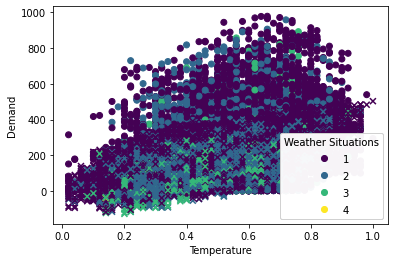

In [0]:
#we can see that more the ideal temperature is 0.7. and the best weater is 1 and 2
import matplotlib.pyplot as plt
import pandas as pd

pred_ = pred.toPandas()
#pred_ = pred_.groupby("temp").mean()
fig, ax = plt.subplots()
scatter = ax.scatter(pred_['temp'], pred_["demand"], c=pred_["weathersit"])
ax.scatter(pred_['temp'], pred_["prediction"], c=pred_["weathersit"], marker="x")
legend = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Weather Situations")
ax.add_artist(legend)
ax.set_xlabel("Temperature")
ax.set_ylabel("Demand")
plt.show()

## Model improovement

### Data Visualization

In this part, I try to understant what is the dataset

In [0]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler,StringIndexer,MinMaxScaler

In [0]:
rowData = spark.read.csv("/FileStore/tables/Bike_Rental_UCI_dataset.csv", inferSchema=True, header = True)

In [0]:
print(
    rowData.groupBy('mnth').count().show(),
    rowData.groupBy('yr').count().show(),
    rowData.groupBy('season').count().show(),
    rowData.groupBy('dayOfWeek').count().show(),
    rowData.groupBy('weathersit').count().show()
     )

+----+-----+
|mnth|count|
+----+-----+
|  12| 1483|
|   1| 1429|
|   6| 1440|
|   3| 1473|
|   5| 1488|
|   9| 1437|
|   4| 1437|
|   8| 1475|
|   7| 1488|
|  10| 1451|
|  11| 1437|
|   2| 1341|
+----+-----+

+---+-----+
| yr|count|
+---+-----+
|  1| 8734|
|  0| 8645|
+---+-----+

+------+-----+
|season|count|
+------+-----+
|     1| 4242|
|     3| 4496|
|     4| 4232|
|     2| 4409|
+------+-----+

+---------+-----+
|dayOfWeek|count|
+---------+-----+
|      Sun| 2502|
|      Mon| 2479|
|      Sat| 2512|
|      Wed| 2475|
|      Tue| 2453|
|      Fri| 2487|
|      Thr| 2471|
+---------+-----+

+----------+-----+
|weathersit|count|
+----------+-----+
|         1|11413|
|         3| 1419|
|         4|    3|
|         2| 4544|
+----------+-----+

None None None None None


### Data Preparation

#### In this part, we apply one hot encoding to have a good data format

In [0]:
# I transform all the data into numericals, and I drop the non numericals
indexer = StringIndexer(inputCol='dayOfWeek', outputCol='day_cat')
indexed_data =indexer.fit(rowData).transform(rowData)

#removing the old dayOfWeek, and days as they are not usefull for the 
indexed_data = indexed_data.drop('dayOfWeek','days')

indexed_data.show(5)

+------+---+----+---+-------+----------+----------+----+----+---------+------+-------+
|season| yr|mnth| hr|holiday|workingday|weathersit|temp| hum|windspeed|demand|day_cat|
+------+---+----+---+-------+----------+----------+----+----+---------+------+-------+
|     1|  0|   1|  0|      0|         0|         1|0.24|0.81|      0.0|    16|    0.0|
|     1|  0|   1|  1|      0|         0|         1|0.22| 0.8|      0.0|    40|    0.0|
|     1|  0|   1|  2|      0|         0|         1|0.22| 0.8|      0.0|    32|    0.0|
|     1|  0|   1|  3|      0|         0|         1|0.24|0.75|      0.0|    13|    0.0|
|     1|  0|   1|  4|      0|         0|         1|0.24|0.75|      0.0|     1|    0.0|
+------+---+----+---+-------+----------+----------+----+----+---------+------+-------+
only showing top 5 rows



In [0]:
from pyspark.ml.feature import OneHotEncoder

#encode the columns that contains categorical information, for example, the prediction is very different between 7 and 8 am, even if 7 and 8 are similar numbers
encoder = OneHotEncoder(
    inputCols=['season', 'yr','mnth','hr','holiday','workingday','weathersit','day_cat'],
    outputCols=['seasonVec', 'yearVec','mnthVec','hrVec','holidayVec','workingdayVec','weathersitVec','day_catVec']
)

model = encoder.fit(indexed_data)
encoded_data = model.transform(indexed_data)

encoded_data = encoded_data.drop('season', 'yr','mnth','hr','holiday','workingday','weathersit','day_cat')

In [0]:
encoded_data.show(2)

+----+----+---------+------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+-------------+
|temp| hum|windspeed|demand|    seasonVec|      yearVec|       mnthVec|         hrVec|   holidayVec|workingdayVec|weathersitVec|   day_catVec|
+----+----+---------+------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+-------------+
|0.24|0.81|      0.0|    16|(4,[1],[1.0])|(1,[0],[1.0])|(12,[1],[1.0])|(23,[0],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(4,[1],[1.0])|(6,[0],[1.0])|
|0.22| 0.8|      0.0|    40|(4,[1],[1.0])|(1,[0],[1.0])|(12,[1],[1.0])|(23,[1],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(4,[1],[1.0])|(6,[0],[1.0])|
+----+----+---------+------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+-------------+
only showing top 2 rows



In [0]:
col = ['seasonVec', 'yearVec','mnthVec','hrVec','holidayVec','workingdayVec','weathersitVec','day_catVec','temp','hum','windspeed']

In [0]:
# I put all the features in one column
vector= VectorAssembler(inputCols=col, outputCol = 'features')

data= vector.transform(encoded_data)

data.show(2,truncate=False)

+----+----+---------+------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+-------------+-----------------------------------------------------------------------------+
|temp|hum |windspeed|demand|seasonVec    |yearVec      |mnthVec       |hrVec         |holidayVec   |workingdayVec|weathersitVec|day_catVec   |features                                                                     |
+----+----+---------+------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+-------------+-----------------------------------------------------------------------------+
|0.24|0.81|0.0      |16    |(4,[1],[1.0])|(1,[0],[1.0])|(12,[1],[1.0])|(23,[0],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(4,[1],[1.0])|(6,[0],[1.0])|(55,[1,4,6,17,40,41,43,46,52,53],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.24,0.81])|
|0.22|0.8 |0.0      |40    |(4,[1],[1.0])|(1,[0],[1.0])|(12,[1],[1.0])|(23,[1],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(4

#### In this part, I normalize the data. It will help to have a good model

In [0]:
standarScaler = StandardScaler(inputCol="features",outputCol="STfeatures")

STdata = standarScaler.fit(data).transform(data)

In [0]:
mmScaler = MinMaxScaler(inputCol="STfeatures",outputCol="NRfeatures")

NRdata = mmScaler.fit(STdata).transform(STdata)

NRdata.select("NRfeatures").show(2,truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------+
|NRfeatures                                                                                                                   |
+-----------------------------------------------------------------------------------------------------------------------------+
|(55,[0,1,4,5,6,17,40,41,42,43,46,52,53],[0.5,1.0,1.0,0.5,1.0,1.0,1.0,1.0,0.5,1.0,1.0,0.22448979591836735,0.8100000000000002])|
|(55,[0,1,4,5,6,18,40,41,42,43,46,52,53],[0.5,1.0,1.0,0.5,1.0,1.0,1.0,1.0,0.5,1.0,1.0,0.2040816326530612,0.8])                |
+-----------------------------------------------------------------------------------------------------------------------------+
only showing top 2 rows



### Model creation

here, I create a linear regression model

In [0]:
# create the data and split the dataset
modelData = NRdata.select('NRfeatures', 'demand') 
trainData, testData = modelData.randomSplit([0.8, 0.2])

In [0]:
#create the linear regression 
lr = LinearRegression(featuresCol="NRfeatures",labelCol='demand')

lrModel = lr.fit(trainData)
predictions = lrModel.transform(testData)

# we can see that the model is good !
print(lrModel.summary.r2)
lrModel.summary.meanAbsoluteError

0.6878711451147401
Out[18]: 75.6831352725529

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="demand",metricName="r2")

lr_evaluator.evaluate(predictions)

Out[19]: 0.6768486746507376

In [0]:
predictions.show()

+----+----+---------+------+-------------+-------------+--------------+---------------+-------------+-------------+-------------+-------------+--------------------+--------------------+--------------------+-------------------+
|temp| hum|windspeed|demand|    seasonVec|      yearVec|       mnthVec|          hrVec|   holidayVec|workingdayVec|weathersitVec|   day_catVec|            features|          STfeatures|          NRfeatures|         prediction|
+----+----+---------+------+-------------+-------------+--------------+---------------+-------------+-------------+-------------+-------------+--------------------+--------------------+--------------------+-------------------+
|0.24|0.81|      0.0|    16|(4,[1],[1.0])|(1,[0],[1.0])|(12,[1],[1.0])| (23,[0],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(4,[1],[1.0])|(6,[0],[1.0])|(55,[1,4,6,17,40,...|(55,[1,4,6,17,40,...|(55,[0,1,4,5,6,17...| -73.68515075525163|
|0.22| 0.8|      0.0|    40|(4,[1],[1.0])|(1,[0],[1.0])|(12,[1],[1.0])| (23,[1],[1.0])|(1,[0

### Model evaluating

In [0]:
print ("explainedVariance={}".format(lrModel.summary.explainedVariance))
print ("meanAbsoluteError=%g" %lrModel.summary.meanAbsoluteError)

explainedVariance=22955.45671239326
meanAbsoluteError=75.6831


In [0]:
# Resduals
testResults = lrModel.evaluate(testData)

testResults.residuals.show(n=10,truncate=False)


from pyspark.sql.functions import abs
df= testResults.residuals
df.select(abs(df.residuals)).groupBy().avg().show(truncate=False)


+------------------+
|residuals         |
+------------------+
|130.15017178182137|
|103.77306953453561|
|112.80774686906095|
|159.27581241125534|
|110.16956394934813|
|128.05950925287829|
|142.30294164760573|
|117.74591076699849|
|120.7307797711443 |
|125.59450818278057|
+------------------+
only showing top 10 rows

+-------------------+
|avg(abs(residuals))|
+-------------------+
|74.60619316599325  |
+-------------------+



In [0]:
print ("r2=%g"%testResults.r2)   # my model explains x % of the variance of the data

r2=0.676849


### Model improovement

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline

# create a new pipeline with the dummy variables included
final_pipeline = Pipeline(stages=[lr])

# create the parameter grid for cross-validation
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

cv = CrossValidator(estimator=final_pipeline, estimatorParamMaps=param_grid, evaluator=lr_evaluator, numFolds=5)

# fit the cross-validator to the data
cv_model = cv.fit(trainData)

#transform on test data
tuned_lr_accuracy = lr_evaluator.evaluate(cv_model.transform(testData))
tuned_lr_mae = lr_evaluator.evaluate(cv_model.transform(testData),{lr_evaluator.metricName: "mae"})

print("tuned logistic regression accuracy: {}".format(tuned_lr_accuracy))

print("tuned logistic regression mae: {}".format(tuned_lr_mae))

tuned logistic regression accuracy: 0.6769113321471885
tuned logistic regression mae: 74.5997047411219


###Other machine learning models

#### Decision Tree

In [0]:
from pyspark.ml.regression import DecisionTreeRegressor

# create the models
dt = DecisionTreeRegressor(featuresCol="NRfeatures", labelCol="demand")

#The pipelines
dt_pipeline = Pipeline(stages=[dt])

# create the parameter grids for each model
dt_param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10,15,20]) \
    .build()

# set up the cross-validators for each model
dt_cv = CrossValidator(estimator=dt_pipeline, estimatorParamMaps=dt_param_grid, evaluator=lr_evaluator, numFolds=5)

# fit the cross-validators to the data and evaluate the best models
dt_cv_model = dt_cv.fit(trainData)

#get best models
best_dt_model = dt_cv_model.bestModel

#predictions
dt_predictions = best_dt_model.transform(testData)

#evaluation
dt_mae = lr_evaluator.evaluate(dt_predictions,{lr_evaluator.metricName: "mae"})

dt_r2 = lr_evaluator.evaluate(dt_predictions)

print(f"Decision tree model MAE: {dt_mae}")

print(f"Decision tree model MAE: {dt_r2}")

Decision tree model MAE: 44.97410004274055
Decision tree model MAE: 0.8347157751267926


#### Random forest

In [0]:
from pyspark.ml.regression import RandomForestRegressor

# create the models
rf = RandomForestRegressor(featuresCol="NRfeatures", labelCol="demand")

#The pipelines
rf_pipeline = Pipeline(stages=[rf])

# create the parameter grids for each model

rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10,15,20]) \
    .addGrid(rf.numTrees, [10, 20]) \
    .build()

# set up the cross-validators for each model
rf_cv = CrossValidator(estimator=rf_pipeline, estimatorParamMaps=rf_param_grid, evaluator=lr_evaluator, numFolds=5)


# fit the cross-validators to the data and evaluate the best models
rf_cv_model = rf_cv.fit(trainData)

#get best models
best_rf_model = rf_cv_model.bestModel

#predictions
rf_predictions = best_rf_model.transform(testData)

#evaluation
rf_mae = lr_evaluator.evaluate(rf_predictions,{lr_evaluator.metricName: "mae"})
rf_r2 = lr_evaluator.evaluate(rf_predictions)

print(f"Random forest model MAE: {rf_mae}")
print(f"Random forest model r2: {rf_r2}")

Random forest model MAE: 37.89661300591429
Random forest model r2: 0.8956798171066394
